# Data Preprocessing

Sources:

apriori:
Geeks for Geeks article: https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/

networkx graph:
https://innovationyourself.com/association-rules-learning/

In [ ]:
import pandas as pd

df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

## Separate prediabetic and diabetic datasets

In [ ]:
#columns to be included
selected_features = ["HighBP", "HighChol", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack",
                     "GenHlth", "Age" , "Education", "Income", "NoDocbcCost", "DiffWalk"]


#prediabetes dataframe
df_pred = df[df["Diabetes_012"] ==1]
df_pred = df_pred[selected_features]

#diabetes dataframe
df_diab = df[df["Diabetes_012"]==2]
df_diab = df_diab[selected_features]


## Bin data

In [ ]:
import numpy as np

#bin data for prediabetes dataset
df_pred["BMIBin"] = pd.cut(df_pred['BMI'], bins=[0, 18.4, 24.9, 29.9, 40], labels=["Underweight", "Normal", "Overweight", "Obese"])
df_pred['ageBin'] = pd.cut(df_pred['Age'], bins=[0, 2, 5, 8, 13], labels=["18-29", "30-44", "45-59", "60+"])


#bin data for diabetes dataset
df_diab["BMIBin"] = pd.cut(df_diab['BMI'], bins=[0, 18.4, 24.9, 29.9, 40], labels=["Underweight", "Normal", "Overweight", "Obese"])
df_diab['ageBin'] = pd.cut(df_diab['Age'], bins=[0, 2, 5, 8, 13], labels=["18-29", "30-44", "45-59", "60+"])


# Transform the Data for Mining

In [ ]:

binary_v = ["HighBP", "HighChol", "Smoker", "HeartDiseaseorAttack", "NoDocbcCost", "DiffWalk", "Stroke"]
binned_v = ["GenHlth", "ageBin", "Education", "BMIBin"]


#transform prediabetes dataframe into transaction format
pred_list = []
for row in df_pred.itertuples():
    
    row_list = []
    for v in binary_v:
        if getattr(row, v) == 1:
            row_list.append(v)
    
    
    for v in binned_v:
        bin_value = getattr(row, v)
        row_list.append(f"{v}: {bin_value}")
    

    pred_list.append(row_list)



In [ ]:
#transform diabetes dataframe into transaction format
diab_list = []
for row in df_diab.itertuples():
    
    row_list = []
    for v in binary_v:
        if getattr(row, v) == 1:
            row_list.append(v)
    
    
    for v in binned_v:
        bin_value = getattr(row, v)
        row_list.append(f"{v}: {bin_value}")
    

    diab_list.append(row_list)



In [ ]:
#One-hot encoding of the transactions for pre-diabetes
from mlxtend.preprocessing import TransactionEncoder
transactions = pred_list
encoder = TransactionEncoder()
encoded = encoder.fit(transactions).transform(transactions)
encoded_pred_df = pd.DataFrame(encoded, columns=encoder.columns_)
encoded_pred_df.head()

#One-hot encoding of the transactions for diabetes
transactions = diab_list
encoder = TransactionEncoder()
encoded = encoder.fit(transactions).transform(transactions)
encoded_diab_df = pd.DataFrame(encoded, columns=encoder.columns_)
encoded_diab_df.head()


# Apply Association Rule Mining

## Prediabetic Dataset

In [282]:
from mlxtend.frequent_patterns import apriori, association_rules 

# min_support=0.05 -> looking for itemsets that appear in at least 5% of the transactions
frequent_itemsets = apriori(encoded_pred_df, min_support=0.05, use_colnames=True)

# Generate the association rules from the frequent itemsets
# Use 'lift' as a metric + set a minimum threshold of 1.0 for the lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)


# Sort the rules by lift and display the top 5 rules
pred_top_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(5)

pred_top_rules

,antecedents,consequents,support,confidence,lift
40,(DiffWalk),(GenHlth: 5.0),0.058735,0.211673,2.792759
41,(GenHlth: 5.0),(DiffWalk),0.058735,0.774929,2.792759
1356,"(ageBin: 60+, GenHlth: 4.0)","(HighBP, DiffWalk)",0.053768,0.444643,2.185925
1357,"(HighBP, DiffWalk)","(ageBin: 60+, GenHlth: 4.0)",0.053768,0.264331,2.185925
1362,(DiffWalk),"(ageBin: 60+, HighBP, GenHlth: 4.0)",0.053768,0.193774,2.007537


## Diabetic Dataset

In [283]:
# min_support=0.05 -> looking for itemsets that appear in at least 5% of the transactions
frequent_itemsets = apriori(encoded_diab_df, min_support=0.05, use_colnames=True)

# Generate the association rules from the frequent itemsets
# Use 'lift' as a metric + set a minimum threshold of 1.0 for the lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Step 11: Format the output
# Sort the rules by lift and display the top 5 rules
diab_top_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(5)

diab_top_rules

,antecedents,consequents,support,confidence,lift
2098,(GenHlth: 5.0),"(HighBP, DiffWalk, Smoker)",0.053896,0.416121,2.382666
2087,"(HighBP, DiffWalk, Smoker)",(GenHlth: 5.0),0.053896,0.308602,2.382666
2078,"(DiffWalk, HighChol)","(HighBP, GenHlth: 5.0)",0.068353,0.255743,2.370699
2079,"(HighBP, GenHlth: 5.0)","(DiffWalk, HighChol)",0.068353,0.633622,2.370699
2092,"(DiffWalk, Smoker)","(HighBP, GenHlth: 5.0)",0.053896,0.252820,2.343609


# Visualize Findings: NetworkX Graph

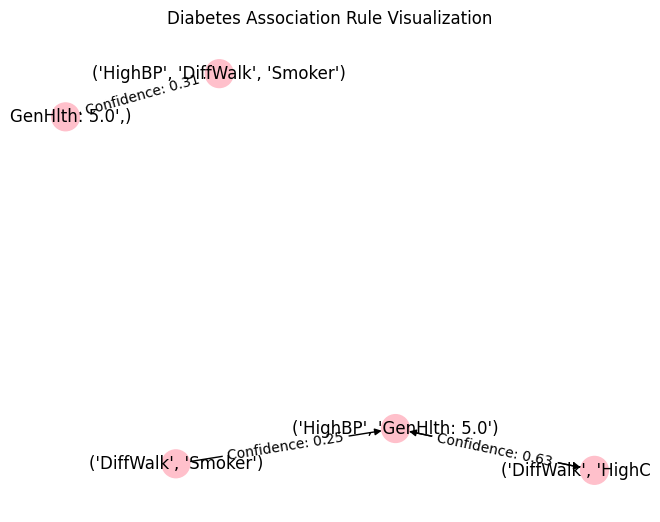

In [284]:
# Create a directed graph for top association rules in diabetes dataset
G = nx.DiGraph()

# Add nodes
for item in diab_top_rules['antecedents']:
    G.add_node(tuple(item), shape='ellipse', style='filled', fillcolor='lightblue')
for item in diab_top_rules['consequents']:
    G.add_node(tuple(item), shape='ellipse', style='filled', fillcolor='pink')

# Add edges
for idx, row in diab_top_rules.iterrows():
    G.add_edge(tuple(row['antecedents']), tuple(row['consequents']), label=f"Confidence: {row['confidence']:.2f}")

# Plot the graph
pos = nx.spring_layout(G, seed=26)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, node_size=400, node_color=['lightblue' if 'antecedents' in node else 'pink' for node in G.nodes()])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Diabetes Association Rule Visualization")
plt.show()


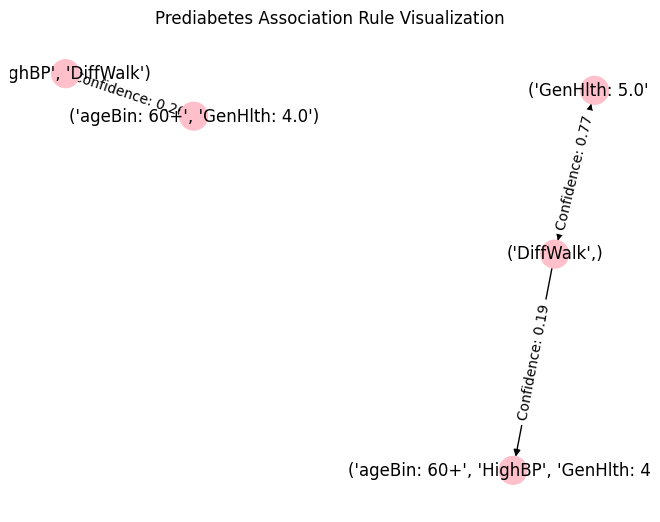

In [285]:
# Create a directed graph for top association rules in prediabetes dataset
G = nx.DiGraph()

# Add nodes
for item in pred_top_rules['antecedents']:
    G.add_node(tuple(item), shape='ellipse', style='filled', fillcolor='lightblue')
for item in pred_top_rules['consequents']:
    G.add_node(tuple(item), shape='ellipse', style='filled', fillcolor='pink')

# Add edges
for idx, row in pred_top_rules.iterrows():
    G.add_edge(tuple(row['antecedents']), tuple(row['consequents']), label=f"Confidence: {row['confidence']:.2f}")

# Plot the graph
pos = nx.spring_layout(G, seed=26)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, node_size=400, node_color=['lightblue' if 'antecedents' in node else 'pink' for node in G.nodes()])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Prediabetes Association Rule Visualization")
plt.show()
